In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

640 426


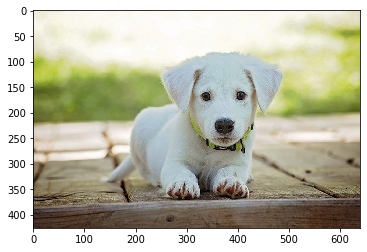

In [2]:
# reading image and its parameters
imgColor = cv2.imread('puppy.png')
imgColor = cv2.cvtColor(imgColor, cv2.COLOR_BGR2RGB)
Gray = cv2.cvtColor(imgColor, cv2.COLOR_BGR2GRAY)
height = Gray.shape[0]
width = Gray.shape[1]
print(width,height)
plt.imshow(imgColor)

# generating edgeMap using sobel filter
edgeMap = cv2.Sobel(Gray,cv2.CV_64F,1,1,ksize=5)
edgeMap = np.uint8(edgeMap)

704


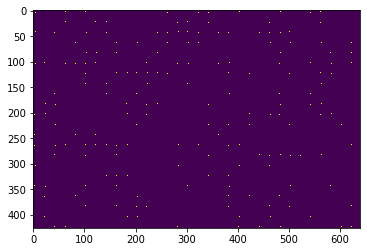

In [3]:
mask = np.zeros((Gray.shape))
sp_centres = []
sp_colors = []

S = 20

i = 3
while(i<height):
    j=3
    while(j<width):
        if(edgeMap[i][j]==1 or edgeMap[i][j]==0):
            sp_centres.append((i,j))                   # appending superpixel centres if pixel value is 0 or 1
            sp_colors.append((imgColor[i][j][0],imgColor[i][j][1],imgColor[i][j][2]))
            
            mask[i][j] = 255
        else:
            nb = edgeMap[i-1:i+2,j-1:j+2]
            minval = nb.min()                   
            
            for x1 in range(i-1,i+2):
                for y1 in range(j-1,j+2):
                    if(edgeMap[x1][y1]==minval): 
                        x = x1
                        y = y1
                        break
            sp_centres.append((x,y)) # appending superpixel centres on the basis of min value of neighbourhood
            sp_colors.append((imgColor[x][y][0],imgColor[x][y][1],imgColor[x][y][2]))
            mask[x][y] = 255
        j+=S   #stride = 10
    i+=S
plt.imshow(mask)                 # show superpixel Mask
print(len(sp_centres))


In [6]:
distance_matrix = np.zeros((imgColor.shape))

m = 20                      # m value

def takeSecond(elem):
    return elem[1]
def takeFirst(elem):
    return elem[0]

def distance(quadcentres,i,j):
    dist = []
    for quad in quadcentres:
        a,b = quad
        dist.append((quad,(math.sqrt((a-i)**2 + (b-j)**2))))
    dist.sort(key=takeSecond)       # sorting and appending superpixels nearest to pixel in 2S*2S window
            
    distList = []
    for k in range(0,min(4,len(dist))):
        val = dist[k]
        coord,dspace = val
        s,p = coord
        r1 = imgColor[i][j][0]
        g1 = imgColor[i][j][1]
        b1 = imgColor[i][j][2]

        r2 = imgColor[s][p][0]
        g2 = imgColor[s][p][1]
        b2 = imgColor[s][p][2]

        dcolor = math.sqrt((r2-r1)**2 + (g2-g1)**2 + (b2-b1)**2) # calculating dcolor
        D = dcolor + (m/S)*dspace                                # calculating d value for SLIC
        distList.append((D,r2,g2,b2))
    distList.sort(reverse=True,key=takeFirst)                   
    t,u,v,x = distList[0]                                        # getting max d value superpixel
    distance_matrix[i][j][0] = u
    distance_matrix[i][j][1] = v
    distance_matrix[i][j][2] = x

In [7]:
for i in range(height):
    for j in range(width):
        quadcentres = []
        if(i>S and i+S< height and j>S and j+S<width):
            for x in range(i-S,i+S):
                for y in range(j-S,j+S):
                    if(mask[x][y]==255):
                        quadcentres.append((x,y))
                     
        elif(i<S or j<S):
            for x in range(0,2*S+1):
                for y in range(0,2*S+1):
                    if(mask[x][y]==255):
                        quadcentres.append((x,y))

        else:
            nb = mask[i-(i+height-2*S-1):height,j-(j+width-2*S-1):j+(width-j)]
            for x in range(height-2*S-1,height):
                for y in range(width-2*S-1,width):
                    if(mask[x][y]==255):
                        quadcentres.append((x,y))
        
        distance(quadcentres,i,j) # calling distance function to calculate d value for each pixel and adjust its value for its superpixel

/home/anuj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in ubyte_scalars


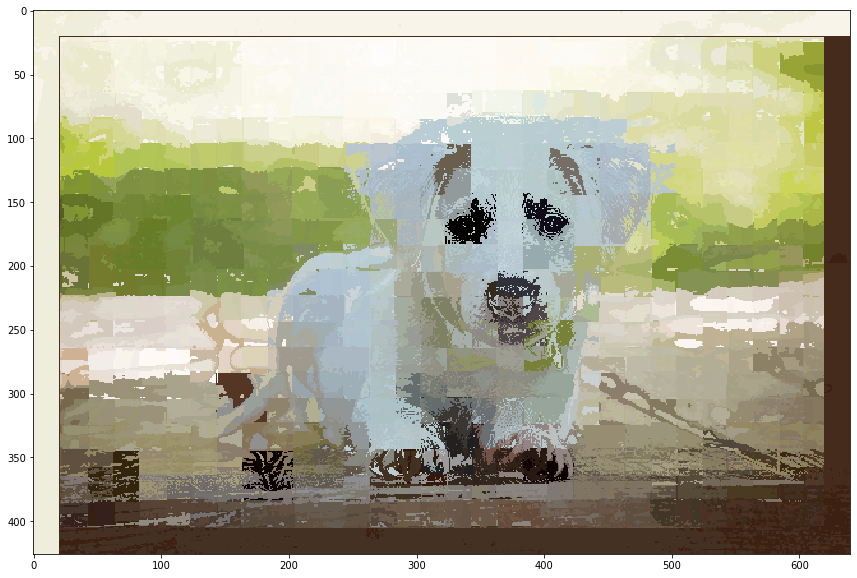

In [8]:
plt.figure(figsize=(15,10))
plt.imshow(distance_matrix.astype('uint8'))           #show final image
plt.savefig('SLIC.png',format = "png", dpi = 300)